In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AIML')

In [ ]:
#import libraries

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split

#importing dATA
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')



<ipython-input-34-8f4f8149ba16>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
#connect to GPU if available from runtime on colab

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#download the dataset

cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

#url https://www.nist.gov/itl/products-and-services/emnist-dataset

In [ ]:
print('\nDat size:')
print(cdata.data.shape)

#transform to 4d tensor for conv layers and trtansorm datafrom int8 to float)

images = cdata.data.view([124800,1,28,28]).float()
print('\nTensor Data:')
print(images.shape)

print('\n',cdata.classes)
print(str(len(cdata.classes))+'classes')


Dat size:
torch.Size([124800, 28, 28])

Tensor Data:
torch.Size([124800, 1, 28, 28])

 ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27classes


In [ ]:
#gettng rid of 'N/A'

print(torch.sum(cdata.targets == 0))
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [ ]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
#trying to remove 'N/A' with slicing 

letterCategories = cdata.classes[1:]

#relabeling data to start with 0 using deepcopy

labels =copy.deepcopy(cdata.targets) -1
print(labels.shape)
print(torch.sum(labels == 0))
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

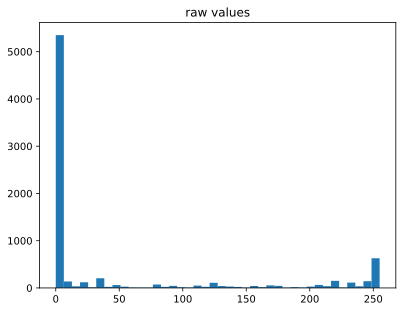

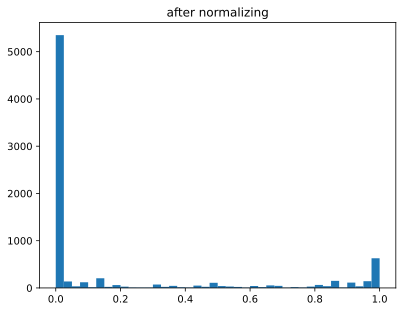

In [ ]:
#normalizing imges


plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('raw values')
plt.show()

images /=torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('after normalizing')
plt.show()


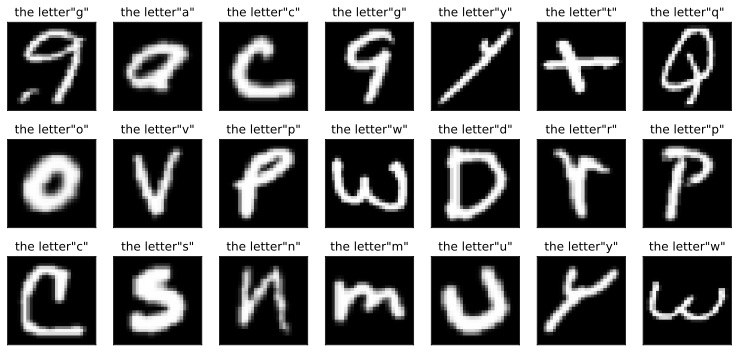

In [ ]:
#visualize some images


fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  
  #random pic
  whichpic =np.random.randint(images.shape[0])
  #extract image and its target letter
  I= np.squeeze(images[whichpic,:,:])
  letter =letterCategories[labels[whichpic]]

  #visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('the letter"%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()




In [ ]:
# 2 create test/train groups using daataloader  using scikilearn to split 

train_data,test_data,train_labels,test_labels = train_test_split(images, labels, test_size = .1)


# 3 convert in pytorch datasets

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data , test_labels)

# 4 translate into dataloader objects

batchsize = 32

train_loader = DataLoader (train_data, batch_size=batchsize,shuffle = True,drop_last=True)
test_loader = DataLoader (test_data, batch_size= test_data.tensors[0].shape[0])






In [ ]:
# check  size should be x images x channels X width X height

print( train_loader.dataset.tensors[0].shape)
print( train_loader.dataset.tensors[1].shape)

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [ ]:
# create DL  model

def makeTheNet(printtoggle=False):
  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      #print toggle
      self.print =printtoggle

      ## __________________________feature map layer_________________________________##
      #forst convolution layer
      self.conv1 = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6)  # number of channels in this
      #output size (28 + 2*1 -3)/1 +1 = 28/2 = 14 ( /2 b/c   maxpooling)


      #second convolution layer
      self.conv2 = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6)  # number of channels in this
      #output size (14 + 2*1 -3)/1 +1 = 14/2 = 7 ( /2 b/c   maxpooling)



      ## __________________________linear decision layer_________________________________##
   
   
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,26)



    def forward(self,x):
      if self.print: print(f'Input: {list(x.shape)}')

      #first block: convolutoin -> maxpool -> batchnorm => relu
      x =F.max_pool2d(self.conv1(x),2)
      x =F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')


      #second block: convolutoin -> maxpool -> batchnorm => relu
      x =F.max_pool2d(self.conv2(x),2)
      x =F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      #reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vecotorized: {list(x.shape)}')

      #linear layer
      x =F.leaky_relu(self.fc1(x))
      x =self.fc2(x)
      if self.print: print(f'Final Output: {list(x.shape)}')

      return x

  #create model instance
  net = emnistnet(printtoggle)

  #loss function
  lossfun = nn.CrossEntropyLoss()

  #optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr = 0.0001)
  return net,lossfun,optimizer

In [ ]:
#test model with one batch

net,lossfun,optimizer = makeTheNet(True)

X,y = iter(train_loader).__next__()
yHat = net(X)

#check the output size
print('\nOutput size:')
print(yHat.shape)


#checking loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss ')
print(loss)

Input: [32, 1, 28, 28]
First CPR block: [32, 6, 14, 14]
Second CPR block: [32, 6, 7, 7]
Vecotorized: [32, 294]
Final Output: [32, 26]

Output size:
torch.Size([32, 26])
 
Loss 
tensor(3.3404, grad_fn=<NllLossBackward0>)


In [ ]:
#train the   Model

def func2trainModel():
  #number of epochs
  numepochs = 20

  #create new model
  net,lossfun,optimizer = makeTheNet()

  #send the model to GPU
  net.to(device)

  #initilize losses
  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)
  trainErr = torch.zeros(numepochs)
  testErr = torch.zeros(numepochs)

  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    net.train()
    batchLoss =[]
    batchErr = []
    for X,y in train_loader:
      #push data to GPU
      X= X.to(device)
      y = y.to(device)

      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append(torch.mean((torch.argmax(yHat,axis =1) != y).float()).item())
    #end of batch loop

    #and get average loss and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi] = 100*np.mean(batchErr)


    #test performance
    net.eval()
    X,y = next(iter(test_loader))  #extract X,y from test dataloader

    #push data to GPU
    X= X.to(device)
    y = y.to(device)

    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)
    
    #get loss and error rate from test btch
    testLoss[epochi] = loss.item()
    testErr[epochi] = 100*torch.mean((torch.argmax(yHat,axis =1) != y).float()).item()

  #end epochs
  #function output
  return trainLoss,testLoss,trainErr,testErr,net


In [ ]:
# run te model and show results
# 2min with 1 ecpoch on gPU   8-10 min  on CPU


trainLoss,testLoss,trainErr, testErr,net = func2trainModel()




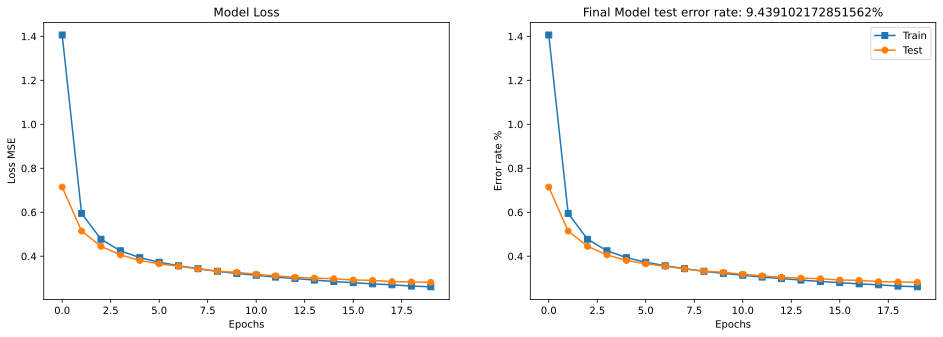

In [ ]:
fig ,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(trainLoss,'s-',label= 'Train')
ax[0].plot(testLoss,'o-',label= 'Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss MSE')
ax[0].set_title('Model Loss')


ax[1].plot(trainLoss,'s-',label= 'Train')
ax[1].plot(testLoss,'o-',label= 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rate %')
ax[1].set_title(f'Final Model test error rate: {testErr[-1]:2}%')
ax[1].legend()

plt.show()








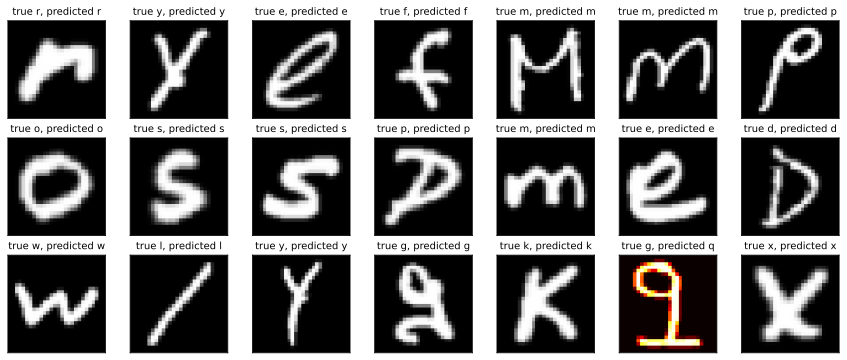

In [ ]:
X,y = next(iter(test_loader))
X =X.to(device)
y = y.to(device)
yHat = net(X)

randex = np.random.choice(len(y),size=21,replace=False)


fig,axs =plt.subplots(3,7,figsize =(15,6))

for i,ax in enumerate (axs.flatten()):

  I = np.squeeze(X[randex[i],0,:,:]).cpu()

  trueLetter = letterCategories[y[randex[i]]]
  predLetter = letterCategories[ torch.argmax(yHat[randex[i],:])]

  col ='gray' if trueLetter == predLetter else 'hot'

  ax.imshow(I.T,cmap=col)
  ax.set_title('true %s, predicted %s' %(trueLetter,predLetter),fontsize = 10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()